# Heart Disease Predictor (Traditional Machine Learning)

### 1) Import Libraries

In [ ]:
# Import libraries and modules

#----- Tools, visualizers -----
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from utils import skewness_detector, outlier_detector
import joblib

#----- Preprocessing -----
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, \
    StandardScaler, MinMaxScaler, RobustScaler, Normalizer
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix

#----- Models -----
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, \
AdaBoostClassifier, ExtraTreesClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.svm import SVC


### 2) Load Data and Inspect

In [6]:
# Load dataset
#---------------
data = pd.read_csv("..\Data\heart-data.csv")
data

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0
...,...,...,...,...,...,...,...,...,...,...,...,...
913,45,M,TA,110,264,0,Normal,132,N,1.2,Flat,1
914,68,M,ASY,144,193,1,Normal,141,N,3.4,Flat,1
915,57,M,ASY,130,131,0,Normal,115,Y,1.2,Flat,1
916,57,F,ATA,130,236,0,LVH,174,N,0.0,Flat,1


### 3) Split Data
Before preprocessing and model training, we need to split the dataset into **train** and **validation** sets.  
- The **training set** is used to learn the patterns.  
- The **validation set** is used to evaluate performance on unseen data, preventing overfitting.  

In [7]:
# Split dataset into train and validation sets
#----------------------------------------------

# Set random state
RANDOM_STATE = 42

# Separate features and labels cols
X = data.drop(columns='HeartDisease') # Features
y = data['HeartDisease'] # Labels

# Split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.15 , random_state=RANDOM_STATE, stratify=y
)

print("----Done----")

----Done----


### Preprocessing
Preprocessing ensures that the dataset is clean, consistent, and suitable for machine learning models.  
In this project, our preprocessing will focus on:  
1. **Handling invalid values**  
   - *RestingBP*: drop rows with 0 (impossible value).  
   - *OldPeak*: replace negative values with 0 (invalid in medical context).  
   - *Cholesterol*: treat 0 as missing values and impute instead of dropping (since there are many).  

2. **Imputation**  
   - For *Cholesterol*, we will impute missing/invalid values.  
   - Options: Mean, Median, or Model-based imputation.  
   - For this project, we will start simple (Median/Mean) then we can test Model-based imputations to compare performance.  

3. **Scaling / Standardization**  
   - Many ML models (e.g., Logistic Regression, SVM, KNN) require features to be on similar scales.  
   - We will apply **StandardScaler** or **MinMaxScaler** depending on the model.  

4. **Encoding categorical features**  
   - Convert categorical variables into numeric form using **One-Hot Encoding** or **Label Encoding** depending on the situation.  

5. *(Optional)* Handling skewness and outliers  
   - For this project, we will skip skewness/outlier handling, since:  
     - Skewness may only affect specific models.  
     - Outliers in medical datasets may represent real patients and should not always be removed.  

After preprocessing, the dataset will be ready to feed into our **Benchmarking Stage** where we compare multiple models.  

---


### 4) Core of preprocessing and handling data
> Including 3-5 steps mentioned above.

- ##### 1) Handling missing values & Imputation


In [8]:
"""
Three continuous numeric features were spotted having INVALID,
 IMPOSSIBLE vlues BIOLOGICLY & in terms of MEDICAL SCIENCE
 * RestingBP -> 1 case with the value 0 (since it's only one case it's better to be removed)
 * OldPeak -> 13 cases with negative values (there are atleast two ways to consider)
    - Replacing negative values with the baseline which is 0 (clipping)
    - Using median imputation
    -> First option is reasonable since number of cases is low
 * Cholesterol -> 172 cases with the value 0 (almost 20% of values)
 - Zeros can be considered as missing values and be imputed by using median/mean or Model-based techniques

"""


# 1. RestingBP preprocessing
#-----------------------------

# Set masks: Keep all rows except the one that's 0
mask_t = X_train['RestingBP'] != 0
mask_v = X_val['RestingBP'] != 0

#  Train
#--------------
# Filter X_train
X_train = X_train[mask_t].reset_index(drop=True)

# Filter y_train
y_train = y_train[mask_t].reset_index(drop=True)

#  Validation
#---------------
# Filter X_val
X_val = X_val[mask_v].reset_index(drop=True)

# Filter y_val
y_val = y_val[mask_v].reset_index(drop=True)


# 2. OldPeak preprocessing
#-----------------------------

# Filter X_train
X_train['Oldpeak'] = X_train['Oldpeak'].apply(lambda x: 0 if x < 0 else x)

# Filter X_val
X_val['Oldpeak'] = X_val['Oldpeak'].apply(lambda x: 0 if x < 0 else x)

# -> Alternative: np.clip()

# 3. Choleterol preprocessing
#-----------------------------

# Median imputation
#-------------------

# Convert zeros into Nan
X_train['Cholesterol'] = X_train['Cholesterol'].replace(0, np.nan)
X_val['Cholesterol'] = X_val['Cholesterol'].replace(0, np.nan)

# Define median imputer
median_imputer = SimpleImputer(strategy='median')

# Apply on X_train
X_train['Cholesterol'] = median_imputer.fit_transform(X_train[['Cholesterol']])

# Apply on X_val
X_val['Cholesterol'] = median_imputer.transform(X_val[['Cholesterol']])

print("----Preprocessing Done----")

----Preprocessing Done----


In [9]:
# Check outliers of X_train after preprocessing to decide which scaler to use
# Safe zone -> outliers < 5%

f = X_train[['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']]
outlier_detector(f)



,feature,n_outliers,outlier_pct
2,Cholesterol,35,4.493
1,RestingBP,23,2.953
4,Oldpeak,12,1.540
3,MaxHR,1,0.128
0,Age,0,0.000


> what remained as outliers are rare but valid observations.
> These aren’t “outliers” in the sense of “bad data,” they’re just part of the true distribution of your population.

In [10]:
# Check skewness of X_train after preprocessing
f = X_train[['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']]
skewness_detector(f) 

,Feature,Skewness,Exceeding_Threshold
0,Age,0.218176,False
1,RestingBP,0.617980,False
2,Cholesterol,1.493441,True
3,MaxHR,0.163001,False
4,Oldpeak,1.100429,True


- ##### 2) Scaling / Standardization

In [11]:
"""
Continuous numeric features should be scaled and standardized
* Including Features: [Age, RestingBP, Cholesterol, MaxHR, Oldpeak]
* First option for sclaing technique could be `StandardScaler` as default
"""

# Specify continuous numeric features
con_num_features = ['Age', 'RestingBP', 'Cholesterol', 'MaxHR', 'Oldpeak']

# Define StandardScaler
std_scaler = StandardScaler()

#  Train
#--------------
X_train_scaled = pd.DataFrame(
    std_scaler.fit_transform(X_train[con_num_features]),
    columns=con_num_features,
    index=X_train.index
    )

#  Validation
#--------------
X_val_scaled = pd.DataFrame(
    std_scaler.transform(X_val[con_num_features]),
    columns=con_num_features,
    index=X_val.index
    )


print("----Scaling & Standardizing Done----")
print("X_train_scaled check:")
print(X_train_scaled.head())
print("X_val_scaled check:")
print(X_val_scaled.head())

----Scaling & Standardizing Done----
X_train_scaled check:
        Age  RestingBP  Cholesterol     MaxHR   Oldpeak
0 -1.149239  -0.045873     0.056355  0.261030 -0.760822
1  1.505420  -0.819128     0.605114  0.571121  0.113768
2  0.337370  -0.045873    -0.675324  1.230065 -0.857999
3  0.655929  -0.156338    -0.693616 -0.165345  1.474241
4 -0.405935   1.500635    -0.126564 -1.018096 -0.857999
X_val_scaled check:
        Age  RestingBP  Cholesterol     MaxHR   Oldpeak
0 -0.299748  -0.432501    -1.022871  0.338553 -0.857999
1  1.717793  -0.156338     1.428253 -1.056857  1.474241
2 -1.680171  -1.260987    -0.126564  0.764928 -0.857999
3 -0.936866   0.285521    -0.144856  0.609882 -0.663646
4 -0.724494  -1.371452    -0.016813  0.609882 -0.857999


- #### 3) Encoding categorical features


In [12]:
"""
Categorical features that aren't numeric type should be encoded to
numerical types.
* Including Features: [Sex, ChestPainType, RestingECG, ExerciseAngina, ST_Slope]
* `FastingBS` was excluded since it's already numeric (binary: 0s 1s)
* The encoders could be used are:
- Label Encoding -> For binary categories
- One-Hot Encoding -> For nominal (no order) or Ordinal (ordered) categories
- Ordinal Encoding -> For ordinal (ordered) categories
* In our case for the features, all of encoders can be used for the corresponding categories:
- Sex, ExerciseAngina (Binary) => Label Encoder
- ChestPainType, RestingECG (Nominal) => One-Hot Encoder
- ST_Slope (Ordinal) => Ordinal  or One-Hot Encoding
"""

# Specify categorical features
bin_features = ['Sex', 'ExerciseAngina']
nom_features = ['ChestPainType', 'RestingECG']
ord_features = ['ST_Slope']

# Define encoders
ohe = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
ore = OrdinalEncoder(categories=[['Down', 'Flat', 'Up']]) 


#-------------
# Train
#-------------

# Label encoding 
X_train_bin_encoded = pd.DataFrame(
    {col: LabelEncoder().fit_transform(X_train[col]) for col in bin_features},
    index=X_train.index
)

# One-hot encoding
X_train_nom_encoded = pd.DataFrame(
    ohe.fit_transform(X_train[nom_features]),
    columns=ohe.get_feature_names_out(nom_features),
    index=X_train.index
)

# Ordinal encoding 
X_train_ord_encoded = pd.DataFrame(
    ore.fit_transform(X_train[ord_features]),
    columns=ord_features,
    index=X_train.index
)


#-------------
# Validation
#-------------

# Label encoding 
X_val_bin_encoded = pd.DataFrame(
    {col: LabelEncoder().fit(X_train[col]).transform(X_val[col]) for col in bin_features},
    index=X_val.index
)

# One-hot encoding
X_val_nom_encoded = pd.DataFrame(
    ohe.transform(X_val[nom_features]),
    columns=ohe.get_feature_names_out(nom_features),
    index=X_val.index
)

# Ordinal encoding 
X_val_ord_encoded = pd.DataFrame(
    ore.transform(X_val[ord_features]),
    columns=ord_features,
    index=X_val.index
)


#-------------
# Concatenate
#-------------

final_X_train = pd.concat([
    X_train['FastingBS'],
    X_train_bin_encoded,
    X_train_nom_encoded, 
    X_train_ord_encoded,
    X_train_scaled], axis=1)


final_X_val = pd.concat([
    X_val['FastingBS'],
    X_val_bin_encoded,
    X_val_nom_encoded, 
    X_val_ord_encoded,
    X_val_scaled], axis=1)


print("----Encoding Done----")
print("final_X_train check:")
final_X_train

----Encoding Done----
final_X_train check:


,FastingBS,Sex,ExerciseAngina,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope,Age,RestingBP,Cholesterol,MaxHR,Oldpeak
0,1,1,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-1.149239,-0.045873,0.056355,0.261030,-0.760822
1,0,1,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,1.505420,-0.819128,0.605114,0.571121,0.113768
2,0,1,1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.337370,-0.045873,-0.675324,1.230065,-0.857999
3,0,1,1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.655929,-0.156338,-0.693616,-0.165345,1.474241
4,1,0,0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,-0.405935,1.500635,-0.126564,-1.018096,-0.857999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
774,0,1,0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,-0.830680,-0.708663,-0.254608,0.532360,-0.857999
775,0,1,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.823979,-0.156338,-0.419236,-0.824289,-0.857999
776,1,1,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.762116,0.064591,-0.126564,-1.948370,0.599651
777,0,1,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.762116,-0.432501,0.879494,-0.824289,-0.857999


### 10) Model Benchmarking 

In [14]:
"""
Check all the models possible to be used for the project,
then FIT, TRAIN, and EVALUATE to see their performances and benchmark.
* Strong cnadidates will be considered for optimization.
"""

# Initialize the models
models = {
    "RandomForest": RandomForestClassifier(random_state=RANDOM_STATE),
    "GradientBoosting": GradientBoostingClassifier(random_state=RANDOM_STATE),
    "AdaBoost": AdaBoostClassifier(random_state=RANDOM_STATE),
    "ExtraTrees": ExtraTreesClassifier(random_state=RANDOM_STATE),
    "DecisionTree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "LogisticRegression": LogisticRegression(random_state=RANDOM_STATE),
    "SVC": SVC(probability=True, random_state=RANDOM_STATE),
    "KNN": KNeighborsClassifier(),
    "GaussianNB": GaussianNB(),
    "BernoulliNB": BernoulliNB(),
    "GaussianProcess": GaussianProcessClassifier()
}


# Train & Evaluate each model and store them in `results` dict
results = []

for name, model in models.items():
    model.fit(final_X_train, y_train)
    y_pred = model.predict(final_X_val)
    
    results.append({
        "Model": name,
        "F1_weighted": f1_score(y_val, y_pred, average='weighted', zero_division=0),
        "F1_macro": f1_score(y_val, y_pred, average='macro', zero_division=0),
        "F1_binary": f1_score(y_val, y_pred, average='binary', zero_division=0),
        "Accuracy": accuracy_score(y_val, y_pred)
    })

# Convert to DataFrame
results_df = pd.DataFrame(results)

# Sort by one or more metrics -> Primary metric: F1 score weighted
results_df = results_df.sort_values(by='F1_weighted', ascending=False).reset_index(drop=True)

results_df

,Model,F1_weighted,F1_macro,F1_binary,Accuracy
0,RandomForest,0.898551,0.897496,0.907895,0.898551
1,GradientBoosting,0.891218,0.890005,0.901961,0.891304
2,AdaBoost,0.884351,0.883667,0.890411,0.884058
3,ExtraTrees,0.884058,0.882852,0.894737,0.884058
4,SVC,0.876713,0.875339,0.888889,0.876812
5,KNN,0.869565,0.868209,0.881579,0.869565
6,GaussianProcess,0.862414,0.861086,0.874172,0.862319
7,LogisticRegression,0.861944,0.860197,0.877419,0.862319
8,GaussianNB,0.847931,0.846464,0.860927,0.847826
9,BernoulliNB,0.833728,0.833114,0.839161,0.833333


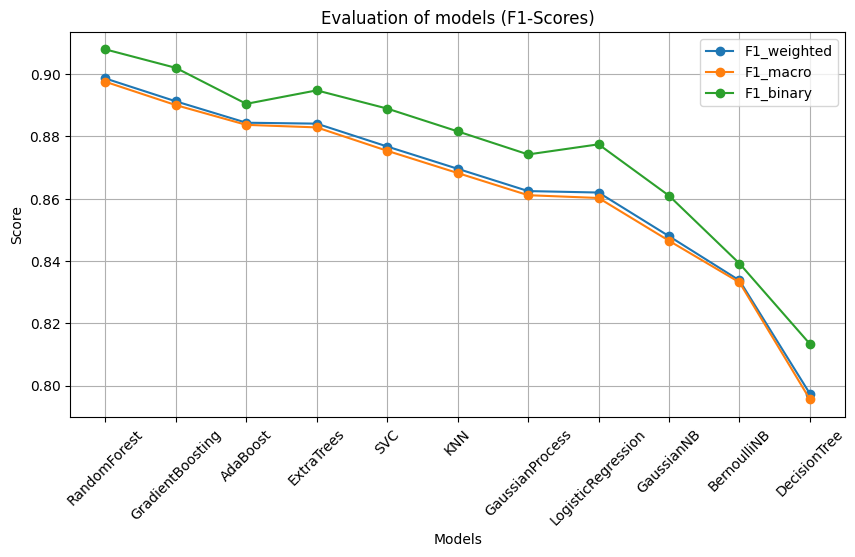

In [15]:
# Plot the benchmarking results
results_df[['F1_weighted', 'F1_macro', 'F1_binary']].plot(
    figsize=(10, 5),
    title="Evaluation of models (F1-Scores)",
    xlabel="Models",
    ylabel="Score",
    xticks=results_df.index,
    grid=True,
    marker='o'
)

# Set x-tick labels to the model names
plt.xticks(ticks=results_df.index, labels=results_df['Model'], rotation=45)
plt.show()


### Hyperparameter tuning

Although hyperparameter tuning (via GridSearchCV, RandomizedSearchCV, or Bayesian optimization) is often considered the next step after benchmarking, in this project I decided to skip it and move directly to the ensembling stage. The reasoning is as follows:

1. **Strong baseline performance:**  
   The best individual models (Random Forest, Gradient Boosting, and AdaBoost) already achieve very high F1 scores (≈0.89–0.90). These results are strong enough that hyperparameter tuning is unlikely to yield significant improvements beyond a few hundredths of a point.

2. **Risk vs. reward:**  
   Hyperparameter tuning is computationally expensive and, in some cases, may even overfit the validation set. Given the current high performance, the marginal benefit is not worth the additional cost.

3. **Ensembling advantage:**  
   Since several top models perform similarly, combining them through ensemble techniques (Voting or Stacking Classifiers) is more likely to provide a stable and possibly higher-performing solution than tuning each individual model.

For these reasons, I will move directly to the ensembling stage, where I will combine the strongest candidates to stabilize and potentially boost performance.


### 11) Build the final model

Voting Classifier:
F1-Score (weighted): 88.406 %
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        62
           1       0.89      0.89      0.89        76

    accuracy                           0.88       138
   macro avg       0.88      0.88      0.88       138
weighted avg       0.88      0.88      0.88       138

Stacking Classifier:
F1-Score (weighted): 89.122 %
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88        62
           1       0.90      0.91      0.90        76

    accuracy                           0.89       138
   macro avg       0.89      0.89      0.89       138
weighted avg       0.89      0.89      0.89       138



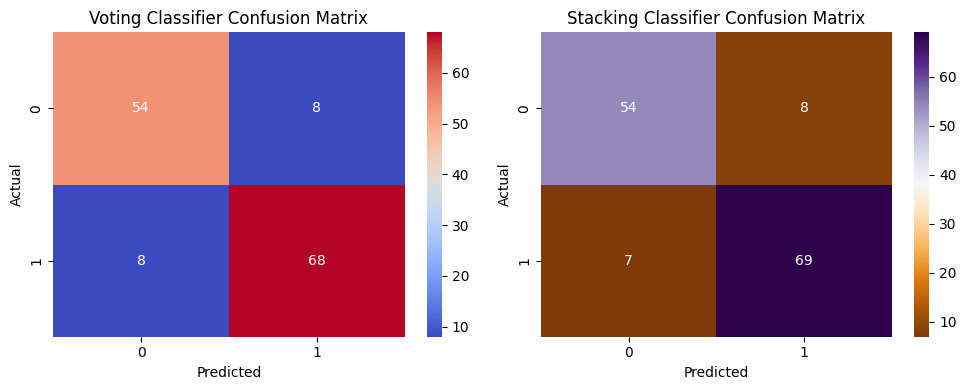

In [16]:
"""
There are multiple models with almost the same performance, 
These strong candidates can be combined to stabilize and potentially boost performance.
* Ensembeling Techniques:
- Voting Classifier
    - Equal weights are fine to start, but tuning weights can squeeze out extra performance.
- Stacking Classifier
    - If base models are diverse & strong, a simple meta-model like LogisticRegression is often best.
    - If they're weak or very different, a more flexible meta-model (like GradientBoosting) might help.
"""

# ----- Voting Classifier -----

voting_model = VotingClassifier(
    estimators=[
        ("RF", RandomForestClassifier(random_state=RANDOM_STATE)),
        ("GB", GradientBoostingClassifier(random_state=RANDOM_STATE)),
        ("ADA", AdaBoostClassifier(random_state=RANDOM_STATE))
    ],
    voting="soft", weights=[1, 1, 1]
)

# Fit
voting_model.fit(final_X_train, y_train)
# Predict
voting_y_pred = voting_model.predict(final_X_val)

#----- Evaluate -----
print("Voting Classifier:")
# F1-score
print(f"F1-Score (weighted): {round(f1_score(y_val, voting_y_pred, average='weighted') * 100, 3)} %")
# Classification report
print(f"Classification Report:\n{classification_report(y_val, voting_y_pred)}")
# Confusion matrix
voting_cw = confusion_matrix(y_val, voting_y_pred)



# ----- Stacking Classifier -----

stacking_model = StackingClassifier(
    estimators=[
        ("RF", RandomForestClassifier(random_state=RANDOM_STATE)),
        ("GB", GradientBoostingClassifier(random_state=RANDOM_STATE)),
        ("ADA", AdaBoostClassifier(random_state=RANDOM_STATE)),
        ("ET", ExtraTreesClassifier(random_state=RANDOM_STATE)),
        ("SVC", SVC(probability=True, random_state=RANDOM_STATE))
    ],
    final_estimator= LogisticRegression(max_iter=1000,random_state=RANDOM_STATE)
)


# Fit
stacking_model.fit(final_X_train, y_train)
# Predict
stacking_y_pred = stacking_model.predict(final_X_val)

#----- Evaluate -----
print("Stacking Classifier:")
# F1-score
print(f"F1-Score (weighted): {round(f1_score(y_val, stacking_y_pred, average='weighted') * 100, 3)} %")
# Classification report
print(f"Classification Report:\n{classification_report(y_val, stacking_y_pred)}")
# Confusion matrix
stacking_cw = confusion_matrix(y_val, stacking_y_pred)


#----- Visualize confusion matrix -----
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Visualize voting classifier
sns.heatmap(voting_cw, annot=True, cmap='coolwarm', ax=axes[0])
axes[0].set_title("Voting Classifier Confusion Matrix")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Actual")


# Visualize stacking classifier
sns.heatmap(stacking_cw, annot=True, cmap='PuOr', ax=axes[1])
axes[1].set_title("Stacking Classifier Confusion Matrix")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Actual")


plt.tight_layout()
plt.show()


In [18]:
#----------------
# Save the model
#----------------

joblib.dump(stacking_model, "../Models/stacking_model.pkl")

print("Model Saved: stacking_model.pkl")

Model Saved: stacking_model.pkl
